In [2]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('D:/week6 data/data.csv')

# Convert TransactionStartTime to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Calculate Recency
max_date = df['TransactionStartTime'].max()
df['recency'] = df.groupby('CustomerId')['TransactionStartTime'].transform(lambda x: (max_date - x).dt.days)

# Calculate Frequency
df['frequency'] = df.groupby('CustomerId')['TransactionId'].transform('count')

# Calculate Monetary
df['monetary'] = df.groupby('CustomerId')['Amount'].transform('sum')

# Create Segment (You can define your own segmentation logic)
df['segment'] = pd.cut(df['monetary'], bins=3, labels=['Low', 'Medium', 'High'])

# Aggregate RFMS features
rfms = df.groupby('CustomerId').agg(
    recency=('recency', 'min'),
    frequency=('frequency', 'max'),
    monetary=('monetary', 'max'),
    segment=('segment', 'first')
).reset_index()

print(f"RFMS Features:\n{rfms.head()}")


RFMS Features:
        CustomerId  recency  frequency  monetary segment
0     CustomerId_1       83          1  -10000.0  Medium
1    CustomerId_10       83          1  -10000.0  Medium
2  CustomerId_1001       89          5   20000.0  Medium
3  CustomerId_1002       25         11    4225.0  Medium
4  CustomerId_1003       11          6   20000.0  Medium


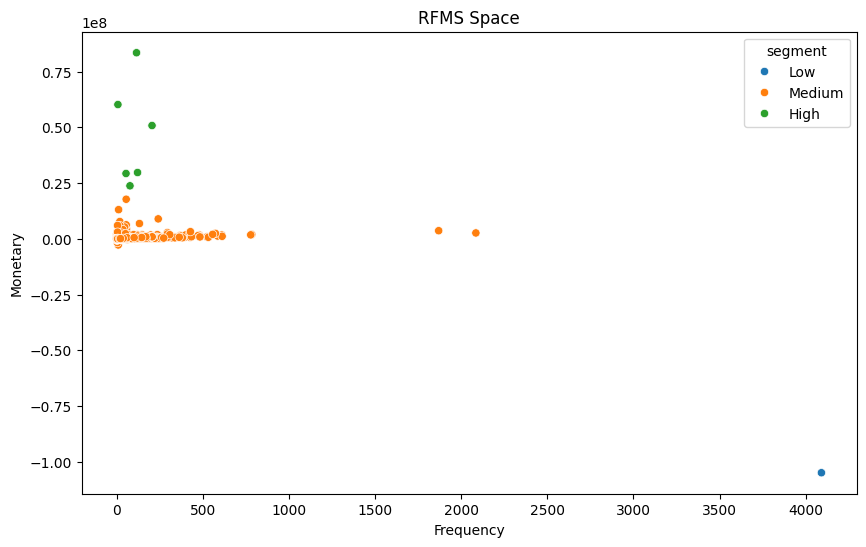

Labeled RFMS Features:
        CustomerId  recency  frequency  monetary segment  RFMS_score label
0     CustomerId_1       83          1  -10000.0  Medium     -9916.0   bad
1    CustomerId_10       83          1  -10000.0  Medium     -9916.0   bad
2  CustomerId_1001       89          5   20000.0  Medium     20094.0  good
3  CustomerId_1002       25         11    4225.0  Medium      4261.0   bad
4  CustomerId_1003       11          6   20000.0  Medium     20017.0   bad


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize RFMS features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfms, x='frequency', y='monetary', hue='segment')
plt.title('RFMS Space')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Simple Boundary: Consider recency, frequency, and monetary thresholds
rfms['RFMS_score'] = rfms['recency'] + rfms['frequency'] + rfms['monetary']
rfms['label'] = np.where(rfms['RFMS_score'] > rfms['RFMS_score'].median(), 'good', 'bad')

print(f"Labeled RFMS Features:\n{rfms.head()}")


In [4]:
from sklearn.preprocessing import KBinsDiscretizer

# Binning using KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
rfms['recency_bin'] = kbins.fit_transform(rfms[['recency']])
rfms['frequency_bin'] = kbins.fit_transform(rfms[['frequency']])
rfms['monetary_bin'] = kbins.fit_transform(rfms[['monetary']])

print(f"Binned RFMS Features:\n{rfms.head()}")


Binned RFMS Features:
        CustomerId  recency  frequency  monetary segment  RFMS_score label  \
0     CustomerId_1       83          1  -10000.0  Medium     -9916.0   bad   
1    CustomerId_10       83          1  -10000.0  Medium     -9916.0   bad   
2  CustomerId_1001       89          5   20000.0  Medium     20094.0  good   
3  CustomerId_1002       25         11    4225.0  Medium      4261.0   bad   
4  CustomerId_1003       11          6   20000.0  Medium     20017.0   bad   

   recency_bin  frequency_bin  monetary_bin  
0          9.0            0.0           0.0  
1          9.0            0.0           0.0  
2          9.0            3.0           5.0  
3          5.0            5.0           2.0  
4          3.0            3.0           5.0  


c:\Users\Robel\.ebcli-virtual-env\Lib\site-packages\sklearn\preprocessing\_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [5]:
def calculate_woe_iv(data, feature, target):
    lst = []
    total_good = len(data[data[target] == 'good'])
    total_bad = len(data[data[target] == 'bad'])
    
    for val in data[feature].unique():
        good = len(data[(data[feature] == val) & (data[target] == 'good')])
        bad = len(data[(data[feature] == val) & (data[target] == 'bad')])
        
        if good == 0:
            good = 1  # To avoid division by zero
        if bad == 0:
            bad = 1  # To avoid division by zero
        
        woe = np.log((good / total_good) / (bad / total_bad))
        iv = ((good / total_good) - (bad / total_bad)) * woe
        lst.append({'Value': val, 'WoE': woe, 'IV': iv})
    
    return pd.DataFrame(lst).sort_values(by='Value')

# Calculate WoE for each feature bin
woe_recency = calculate_woe_iv(rfms, 'recency_bin', 'label')
woe_frequency = calculate_woe_iv(rfms, 'frequency_bin', 'label')
woe_monetary = calculate_woe_iv(rfms, 'monetary_bin', 'label')

print(f"WoE Recency:\n{woe_recency}")
print(f"WoE Frequency:\n{woe_frequency}")
print(f"WoE Monetary:\n{woe_monetary}")


WoE Recency:
   Value       WoE        IV
7    0.0  1.761430  0.221909
9    1.0  0.765082  0.046891
6    2.0  0.594944  0.039724
2    3.0  0.329052  0.011762
8    4.0 -0.098796  0.000962
1    5.0 -0.048368  0.000238
5    6.0 -0.567374  0.027384
3    7.0 -0.674885  0.050169
4    8.0 -0.534108  0.027465
0    9.0 -1.094336  0.110655
WoE Frequency:
   Value       WoE        IV
0    0.0 -1.967568  0.564170
4    1.0 -0.980223  0.059445
8    2.0 -1.572274  0.218616
1    3.0 -1.200559  0.173202
3    4.0  0.234020  0.004969
2    5.0  0.826635  0.065748
6    6.0  1.650528  0.237168
7    7.0  2.970633  0.557023
5    8.0  5.232707  1.039839
WoE Monetary:
   Value       WoE        IV
0    0.0 -5.881828  1.126161
4    1.0 -5.797843  1.020407
2    2.0 -6.064150  1.393932
7    3.0 -5.919980  1.177668
8    4.0 -4.779041  0.604049
1    5.0  0.977885  0.120255
3    6.0  5.879207  1.117913
9    7.0  5.975538  1.251452
5    8.0  5.928532  1.184450
6    9.0  5.931202  1.188160


In [6]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = rfms[['recency_bin', 'frequency_bin', 'monetary_bin']]
y = rfms['label'].apply(lambda x: 1 if x == 'good' else 0)  # Convert labels to binary

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train/Test Split:\nX_train: {X_train.shape}, X_test: {X_test.shape}")


Train/Test Split:
X_train: (2993, 3), X_test: (749, 3)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize models
log_reg = LogisticRegression()
rand_forest = RandomForestClassifier(random_state=42)

In [8]:
# Train Logistic Regression
log_reg.fit(X_train, y_train)

# Train Random Forest
rand_forest.fit(X_train, y_train)

print("Models Trained Successfully")


Models Trained Successfully


In [9]:
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression Evaluation
y_pred_log_reg = log_reg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_log_reg)}")

# Random Forest Evaluation
y_pred_rand_forest = rand_forest.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rand_forest)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rand_forest)}")


Logistic Regression Accuracy: 0.9706275033377837
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       371
           1       0.97      0.97      0.97       378

    accuracy                           0.97       749
   macro avg       0.97      0.97      0.97       749
weighted avg       0.97      0.97      0.97       749

Random Forest Accuracy: 0.9919893190921228
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       371
           1       0.99      0.99      0.99       378

    accuracy                           0.99       749
   macro avg       0.99      0.99      0.99       749
weighted avg       0.99      0.99      0.99       749



In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Grid Search for Logistic Regression
param_grid_log_reg = {'C': [0.1, 1, 10, 100]}
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5)
grid_search_log_reg.fit(X_train, y_train)
print(f"Best Parameters for Logistic Regression: {grid_search_log_reg.best_params_}")

# Random Search for Random Forest
param_dist_rand_forest = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
random_search_rand_forest = RandomizedSearchCV(rand_forest, param_dist_rand_forest, n_iter=50, cv=5, random_state=42)
random_search_rand_forest.fit(X_train, y_train)
print(f"Best Parameters for Random Forest: {random_search_rand_forest.best_params_}")


Best Parameters for Logistic Regression: {'C': 10}


c:\Users\Robel\.ebcli-virtual-env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
85 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Robel\.ebcli-virtual-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Robel\.ebcli-virtual-env\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Robel\.ebcli-virtual-env\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "c:\Use

Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 20}


In [11]:
# Best parameters for Logistic Regression
best_params_log_reg = {'C': 10}

# Train Logistic Regression with best parameters
log_reg_best = LogisticRegression(**best_params_log_reg)
log_reg_best.fit(X_train, y_train)

# Evaluate Logistic Regression
y_pred_log_reg_best = log_reg_best.predict(X_test)
print(f"Logistic Regression Accuracy (Best Parameters): {accuracy_score(y_test, y_pred_log_reg_best)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_log_reg_best)}")


Logistic Regression Accuracy (Best Parameters): 0.9719626168224299
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       371
           1       0.97      0.97      0.97       378

    accuracy                           0.97       749
   macro avg       0.97      0.97      0.97       749
weighted avg       0.97      0.97      0.97       749



In [12]:
# Best parameters for Random Forest
best_params_rand_forest = {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 20}

# Train Random Forest with best parameters
rand_forest_best = RandomForestClassifier(**best_params_rand_forest, random_state=42)
rand_forest_best.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_rand_forest_best = rand_forest_best.predict(X_test)
print(f"Random Forest Accuracy (Best Parameters): {accuracy_score(y_test, y_pred_rand_forest_best)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rand_forest_best)}")


Random Forest Accuracy (Best Parameters): 0.9933244325767691
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       371
           1       0.99      0.99      0.99       378

    accuracy                           0.99       749
   macro avg       0.99      0.99      0.99       749
weighted avg       0.99      0.99      0.99       749



Logistic Regression Accuracy: 0.9719626168224299
Logistic Regression Precision: 0.9709762532981531
Logistic Regression Recall: 0.9735449735449735
Logistic Regression F1 Score: 0.9722589167767504
Logistic Regression ROC-AUC: 0.9980640054764044


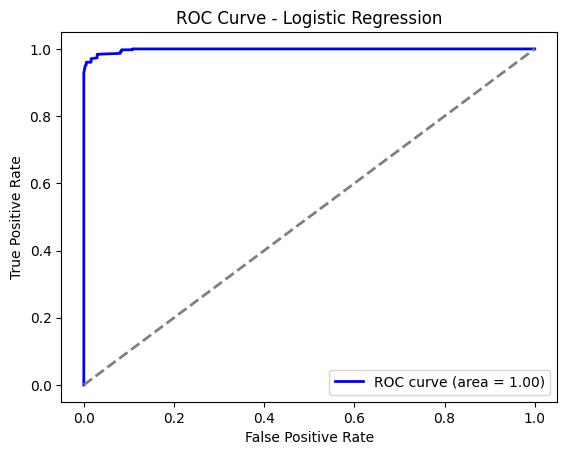

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predictions
y_pred_log_reg_best = log_reg_best.predict(X_test)
y_pred_log_reg_best_prob = log_reg_best.predict_proba(X_test)[:, 1]

# Accuracy
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg_best)
# Precision
precision_log_reg = precision_score(y_test, y_pred_log_reg_best)
# Recall
recall_log_reg = recall_score(y_test, y_pred_log_reg_best)
# F1 Score
f1_log_reg = f1_score(y_test, y_pred_log_reg_best)
# ROC-AUC
roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg_best_prob)

print(f"Logistic Regression Accuracy: {accuracy_log_reg}")
print(f"Logistic Regression Precision: {precision_log_reg}")
print(f"Logistic Regression Recall: {recall_log_reg}")
print(f"Logistic Regression F1 Score: {f1_log_reg}")
print(f"Logistic Regression ROC-AUC: {roc_auc_log_reg}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_log_reg_best_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_log_reg)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Random Forest Accuracy: 0.9933244325767691
Random Forest Precision: 0.9920844327176781
Random Forest Recall: 0.9947089947089947
Random Forest F1 Score: 0.9933949801849405
Random Forest ROC-AUC: 0.9980140903321496


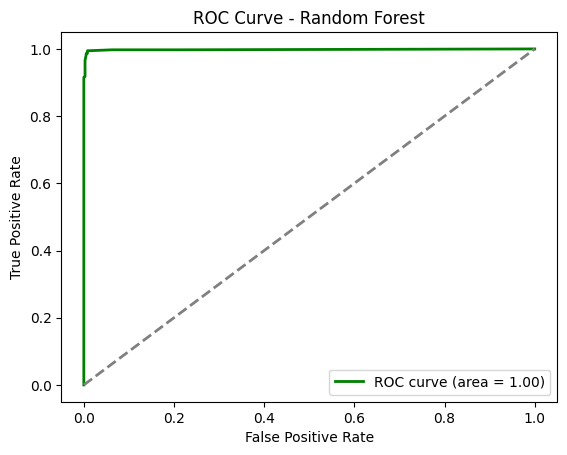

In [14]:
# Predictions
y_pred_rand_forest_best = rand_forest_best.predict(X_test)
y_pred_rand_forest_best_prob = rand_forest_best.predict_proba(X_test)[:, 1]

# Accuracy
accuracy_rand_forest = accuracy_score(y_test, y_pred_rand_forest_best)
# Precision
precision_rand_forest = precision_score(y_test, y_pred_rand_forest_best)
# Recall
recall_rand_forest = recall_score(y_test, y_pred_rand_forest_best)
# F1 Score
f1_rand_forest = f1_score(y_test, y_pred_rand_forest_best)
# ROC-AUC
roc_auc_rand_forest = roc_auc_score(y_test, y_pred_rand_forest_best_prob)

print(f"Random Forest Accuracy: {accuracy_rand_forest}")
print(f"Random Forest Precision: {precision_rand_forest}")
print(f"Random Forest Recall: {recall_rand_forest}")
print(f"Random Forest F1 Score: {f1_rand_forest}")
print(f"Random Forest ROC-AUC: {roc_auc_rand_forest}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_rand_forest_best_prob)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rand_forest)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()
